# Goal
Here we try an experiment to see if we can take unpaired (they happen to be paired in this dataset but we ignore that) images of chest x-rays and segmentations of lungs and learn a forward (X-Ray$\rightarrow$ Lungs) and reverse (Lungs $\rightarrow$ X-ray) mapping using the CycleGAN approach. The basic idea is we have generators for both of the mappings with a U-Net style architecture (which forces them to learn something from the original pixels). We then have discriminators which determine if the images we have created are real or fake. Finally we have the cycle-consistent loss of using both the forward and backward back-to-back which should give us the original images. 

If this works well it could be applied to lots of issues where paired training data are not available. It should also produce more 'realistic' segmentations since the discriminator is actively trying to determine if the image output is discernible real data.

## Setup and Data

In [1]:
!pip install -qq git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
from IPython.display import clear_output
import scipy
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread
import os
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm_notebook
clear_output()

In [3]:
!ls ../input/chest-xray-masks-and-labels/data/Lung\ Segmentation

CXR_png		  NLM-ChinaCXRSet-ReadMe.docx	   masks
ClinicalReadings  NLM-MontgomeryCXRSet-ReadMe.pdf  test


In [4]:
base_path = Path('..') / 'input' / 'chest-xray-masks-and-labels'
all_images_df = pd.DataFrame({'path': list(base_path.glob('**/*.*p*g'))})
all_images_df.sample(3)

,path
596,../input/chest-xray-masks-and-labels/data/Lung...
660,../input/chest-xray-masks-and-labels/data/Lung...
130,../input/chest-xray-masks-and-labels/data/Lung...


In [5]:
all_images_df['modality'] = all_images_df['path'].map(lambda x: x.parent.stem)
all_images_df['source'] = all_images_df['path'].map(lambda x: x.stem.split('_')[0])
all_images_df['image_id'] = all_images_df['path'].map(lambda x: '_'.join(x.stem.split('_')[1:2]))
all_images_df = all_images_df[all_images_df['modality'].isin(['masks', 'CXR_png'])]
print(all_images_df['modality'].value_counts())
all_images_df.sample(3)

CXR_png    800
masks      704
Name: modality, dtype: int64


,path,modality,source,image_id
131,../input/chest-xray-masks-and-labels/data/Lung...,masks,MCUCXR,0017
727,../input/chest-xray-masks-and-labels/data/Lung...,masks,CHNCXR,0416
1413,../input/chest-xray-masks-and-labels/data/Lung...,CXR_png,CHNCXR,0023


In [6]:
all_images_df['path'].values[:4]

array([PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/CHNCXR_0620_1_mask.png'),
       PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/CHNCXR_0238_0_mask.png'),
       PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/CHNCXR_0259_0_mask.png'),
       PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/CHNCXR_0608_1_mask.png')],
      dtype=object)

In [7]:
flat_images_df = all_images_df.pivot_table(index=['source', 'image_id'], 
                          columns='modality', 
                          values='path', 
                          aggfunc='first').\
    reset_index().\
    sort_values('image_id').\
    dropna()
print(flat_images_df.shape[0])
flat_images_df.sample(3)

704


modality,source,image_id,CXR_png,masks
96,CHNCXR,0097,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
654,CHNCXR,0655,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
392,CHNCXR,0393,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...


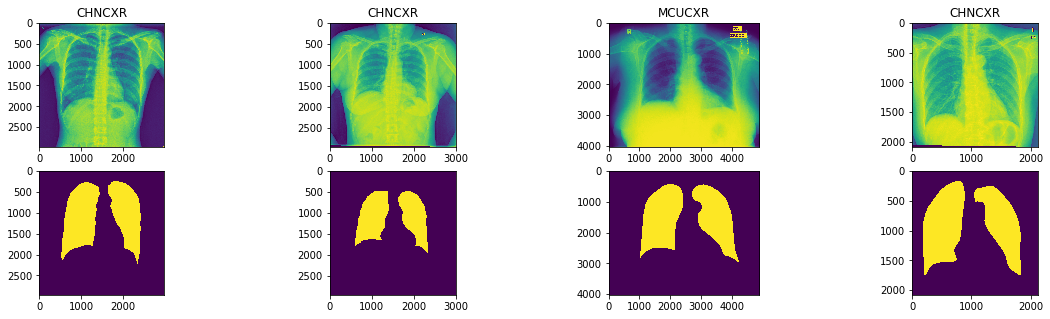

In [8]:
fig, (a_axs, b_axs) = plt.subplots(2, 4, figsize=(20, 5))
for a_ax, b_ax, (_, c_row) in  zip(a_axs, b_axs, flat_images_df.sample(20).iterrows()):
    a_img = imread(c_row['CXR_png'])
    a_ax.imshow(a_img)
    a_ax.set_title(c_row['source'])
    b_img = imread(c_row['masks'])
    b_ax.imshow(b_img)

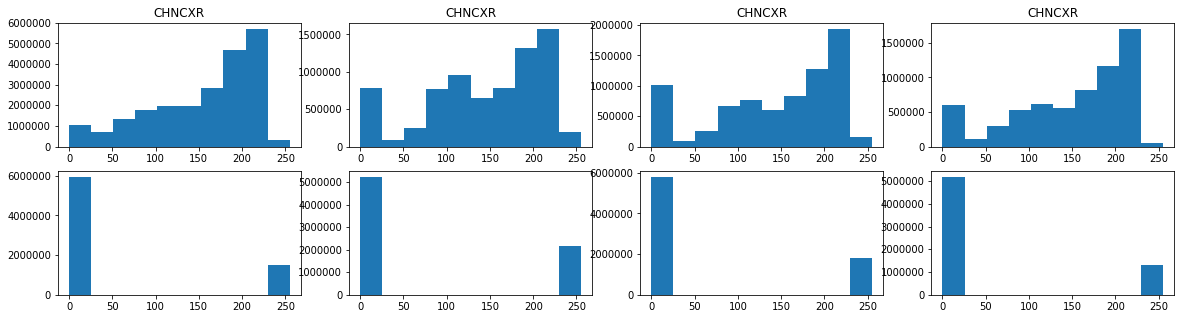

In [9]:
fig, (a_axs, b_axs) = plt.subplots(2, 4, figsize=(20, 5))
for a_ax, b_ax, (_, c_row) in  zip(a_axs, b_axs, flat_images_df.sample(20).iterrows()):
    a_img = imread(c_row['CXR_png'])
    a_ax.hist(a_img.ravel())
    a_ax.set_title(c_row['source'])
    b_img = imread(c_row['masks'])
    b_ax.hist(b_img.ravel())

In [10]:
#all_images_df = all_images_df.sample(4096)
images_a_df = all_images_df[all_images_df['modality']=='CXR_png'].copy()
images_a_df['image_path'] = images_a_df['path'].map(str)
images_b_df = all_images_df[all_images_df['modality']=='masks'].copy()
images_b_df['image_path'] = images_b_df['path'].map(str)

# Setup CycleGAN Code
The code below has been lightly adapted from the code at https://github.com/eriklindernoren/Keras-GAN/tree/master/cyclegan by @eriklindernoren

In [11]:
class CycleGAN():
    def __init__(self,
                 img_rows,
                 img_cols,
                 channels_A,
                 channels_B,
                 parallel_channels=True,
                 ):
        """
        args:
          parallel_channels: process each input and output channel on its own
        """
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels_A = channels_A
        self.channels_B = channels_B
        self.parallel_channels = parallel_channels
        self.img_shape_A = (self.img_rows, self.img_cols, self.channels_A)
        self.img_shape_B = (self.img_rows, self.img_cols, self.channels_B)
        # Calculate output shape of D (PatchGAN)
        patch_r = int(self.img_rows / 2**4)
        patch_c = int(self.img_cols / 2**4)
        self.disc_patch = (patch_r, patch_c, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator(self.img_shape_A, suffix='A')
        self.d_B = self.build_discriminator(self.img_shape_B, suffix='B')
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        # -------------------------
        # Construct Computational
        #   Graph of Generators
        # -------------------------

        # Build the generators
        self.g_AB = self.build_generator(
            self.img_shape_A, self.img_shape_B, suffix='AB')
        self.g_BA = self.build_generator(
            self.img_shape_B, self.img_shape_A, suffix='BA')

        # Input images from both domains
        img_A = Input(shape=self.img_shape_A, name='ImageA')
        img_B = Input(shape=self.img_shape_B, name='ImageB')

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_B)
        img_B_id = self.g_AB(img_A)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

    def build_generator(self, in_img_shape, out_img_shape, suffix=''):
        """U-Net Generator"""
        in_chan = in_img_shape[-1]
        out_chan = out_img_shape[-1]
        gf_down = self.gf // in_chan if self.parallel_channels else self.gf
        gf_up = self.gf // in_chan if self.parallel_channels else self.gf

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size,
                       strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=in_img_shape)
        # Downsampling

        def _ds_pipe(in_d0):
            d1 = conv2d(in_d0, gf_down)
            d2 = conv2d(d1, gf_down*2)
            d3 = conv2d(d2, gf_down*4)
            d4 = conv2d(d3, gf_down*8)
            return d1, d2, d3, d4

        if (in_chan > 1) and self.parallel_channels:
            chan_list = []
            for i in range(in_chan):
                c_d0 = layers.Lambda(
                    lambda x: x[:, :, :, i:(i+1)],
                    name='InSel{}_{}'.format(suffix, i))(d0)
                chan_list.append(_ds_pipe(c_d0))
            d1, d2, d3, d4 = [
                layers.concatenate(list(c_outs))
                for c_outs in zip(*chan_list)]
        else:
            d1, d2, d3, d4 = _ds_pipe(d0)

        # Upsampling
        def _us_pipe(chan_count, d1, d2, d3, d4):
            u1 = deconv2d(d4, d3, gf_up*4)
            u2 = deconv2d(u1, d2, gf_up*2)
            u3 = deconv2d(u2, d1, gf_up)

            u4 = UpSampling2D(size=2)(u3)
            output_img = Conv2D(chan_count, kernel_size=4, strides=1,
                            padding='same', activation='sigmoid')(u4)
            return output_img
        
        
        if (out_chan > 1) and self.parallel_channels:
            chan_list = []
            for i in range(out_chan):
                chan_list.append(_us_pipe(1, d1, d2, d3, d4))
            output_img = layers.concatenate(chan_list)
        else:
            output_img = _us_pipe(out_chan, d1, d2, d3, d4)
        

        return Model(d0, output_img, name='Gen{}_{}_{}_{}-{}'.format(suffix, *in_img_shape, out_img_shape[-1]))

    def build_discriminator(self, img_shape, suffix=''):
        in_chan = img_shape[-1]
        df = self.df // in_chan if self.parallel_channels else self.df

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size,
                       strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=img_shape)

        def _disc_block(in_img):
            d1 = d_layer(in_img, df, normalization=False)
            d2 = d_layer(d1, df*2)
            d3 = d_layer(d2, df*4)
            d4 = d_layer(d3, df*8)
            return d4

        if (in_chan > 1) or not self.parallel_channels:
            chan_list = []
            for i in range(in_chan):
                c_img = layers.Lambda(
                    lambda x: x[:, :, :, i:(i+1)],
                    name='DiscSelect{}_{}'.format(suffix, i))(img)
                chan_list.append(_disc_block(c_img))
            d4 = layers.concatenate(chan_list)
        else:
            d4 = _disc_block(img)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity, name='Disc{}_{}_{}_{}'.format(suffix, *img_shape))

# Model Parameters

In [12]:
IMAGE_SIZE = 128, 128
IMAGE_A_CHANNELS = 1 # X-ray
IMAGE_B_CHANNELS = 1 # Segmentation

# Build Models

In [13]:
cg = CycleGAN(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_A_CHANNELS, IMAGE_B_CHANNELS)

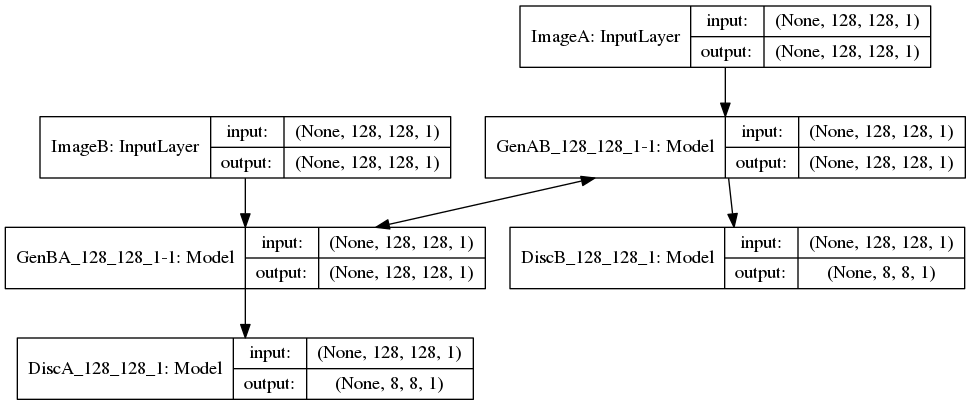

In [14]:
Image(model_to_dot(cg.combined, show_shapes=True).create_png())

## Generators
We just show one and the other can be inferred

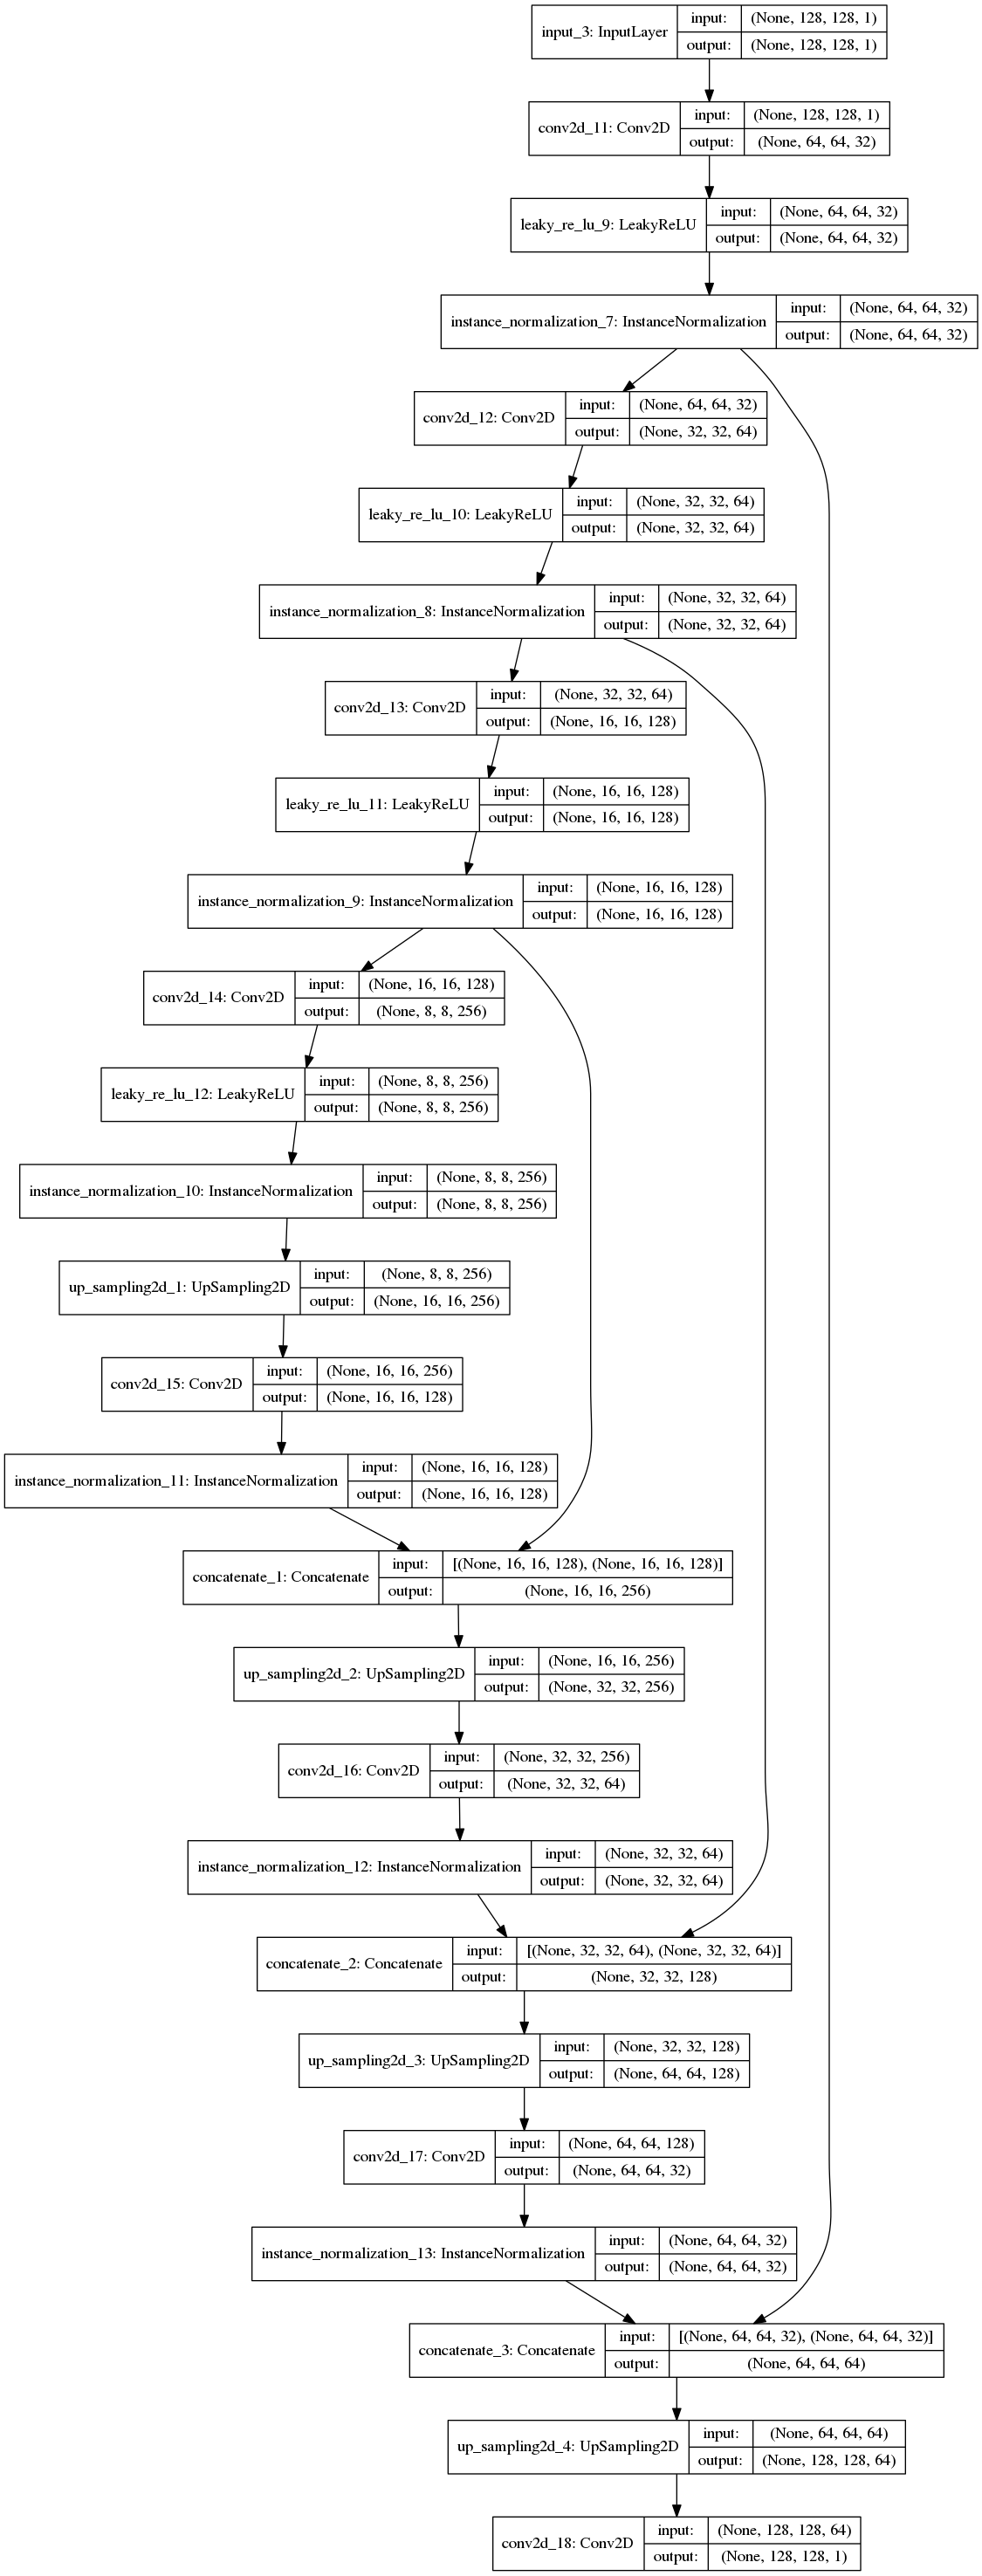

In [15]:
Image(model_to_dot(cg.g_AB, show_shapes=True).create_png())

## Discriminator

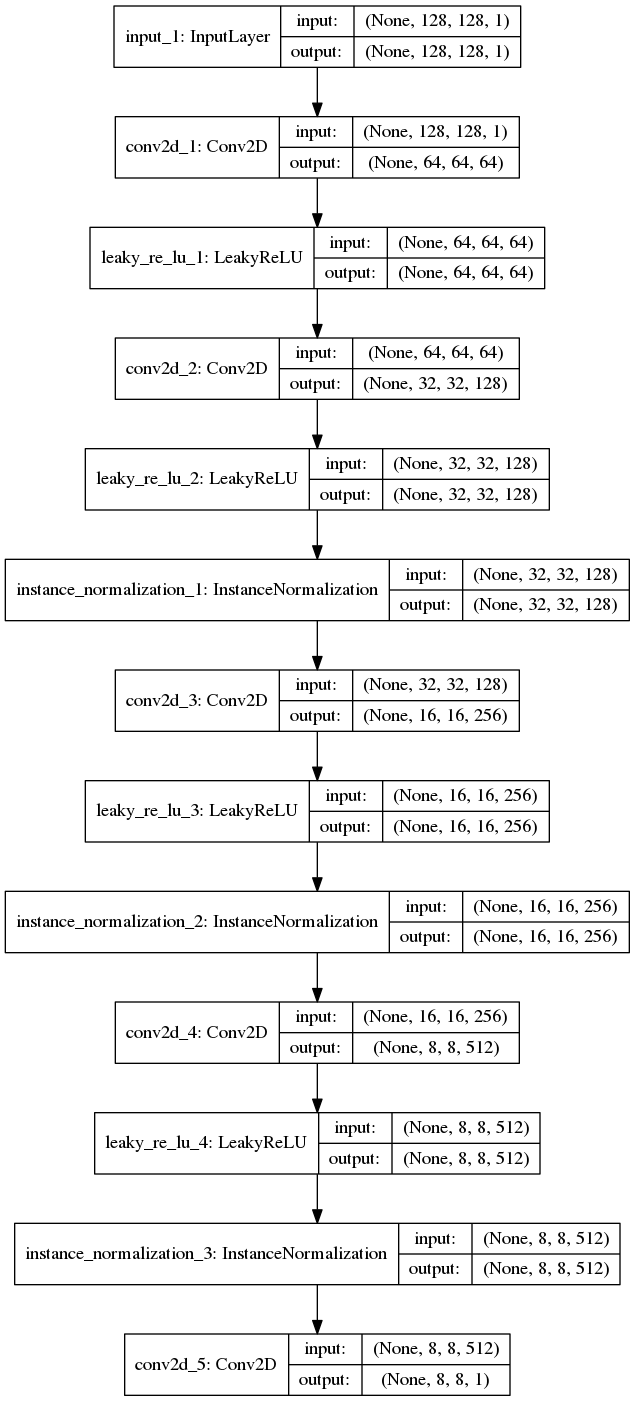

In [16]:
Image(model_to_dot(cg.d_A, show_shapes=True).create_png())

# Data Loaders
Here we setup the data-loaders

In [17]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  rotation_range = 10, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.7, 1.3],
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function=lambda x: x/255.0)

core_idg = ImageDataGenerator(**dg_args)

In [18]:
from sklearn.model_selection import train_test_split

class loader_class():
    def __init__(self, a_df, b_df, goal_size):
        self.goal_size = goal_size
        self.a_df = a_df
        self.b_df = b_df
        self._a_gen = None
        self._b_gen = None
        self.n_batches = 0

    def _make_gen(self, batch_size, use_cached):
        if use_cached and (self._a_gen is not None):
            return self._a_gen, self._b_gen
        
            
        a_gen = core_idg.flow_from_dataframe(self.a_df,
                                               x_col='image_path',
                                               y_col='image_path',
                                               class_mode=None,
                                               target_size=self.goal_size,
                                               color_mode='grayscale',
                                               batch_size=batch_size)
        b_gen = core_idg.flow_from_dataframe(self.b_df,
                                                 x_col='image_path',
                                                 y_col='image_path',
                                                 class_mode=None,
                                                 target_size=self.goal_size,
                                                 color_mode='grayscale',
                                                 batch_size=batch_size)
        if use_cached:
            self._a_gen = a_gen
            self._b_gen = b_gen
        
        return a_gen, b_gen

    def load_batch(self, batch_size):
        a_gen, b_gen = self._make_gen(batch_size, use_cached=False)
        for a_x, b_x in zip(a_gen, b_gen):
            if (a_x.shape[0]==batch_size) and (b_x.shape[0]==batch_size):
                yield a_x, b_x
            else:
                yield None, None

    def load_data(self, domain="A", batch_size=1, is_testing=False):
        a_gen, b_gen = self._make_gen(batch_size, use_cached=True)
        if domain == "A":
            return next(a_gen)
        elif domain == "B":
            return next(b_gen)
        else:
            raise ValueError("Unknown domain")


loader_obj = loader_class(
    a_df=images_a_df, 
    b_df=images_b_df, 
    goal_size=IMAGE_SIZE
)
loader_obj.load_data(domain="A", batch_size=1, is_testing=True).shape

Found 800 validated image filenames.
Found 704 validated image filenames.


(1, 128, 128, 1)

In [19]:
# sanity check on the tool
for _, (a, b) in zip(range(2), loader_obj.load_batch(8)):
    print(a.shape, b.shape)

Found 800 validated image filenames.
Found 704 validated image filenames.
(8, 128, 128, 1) (8, 128, 128, 1)
(8, 128, 128, 1) (8, 128, 128, 1)


## Preview Model Output

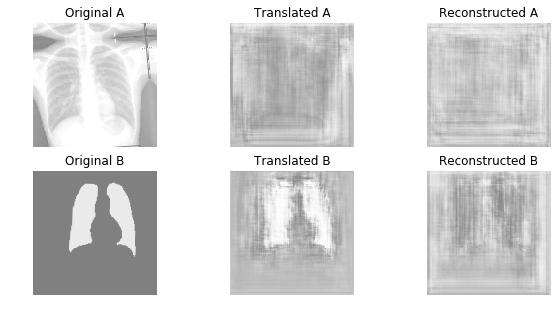

In [20]:
def sample_images(cyc_gan, data_loader, epoch, batch_i):
    plt.close('all')
    r, c = 2, 3

    imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = cyc_gan.g_AB.predict(imgs_A)
    fake_A = cyc_gan.g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = cyc_gan.g_BA.predict(fake_B)
    reconstr_B = cyc_gan.g_AB.predict(fake_A)

    gen_imgs = [imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B]

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c, figsize=(10, 5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            c_img = np.clip(0.5 * gen_imgs[cnt][0]+0.5, 0, 1)
            axs[i,j].imshow(c_img.squeeze(), cmap='gray', vmin=0, vmax=1)
            axs[i, j].set_title('{} {}'.format(titles[j], 'A' if i==0 else 'B'))
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{:03d}_{:03d}.png".format(epoch, batch_i))
sample_images(cg, loader_obj, 0, 0)

# Train Model

In [21]:
BATCH_SIZE = 64
EPOCHS = 30

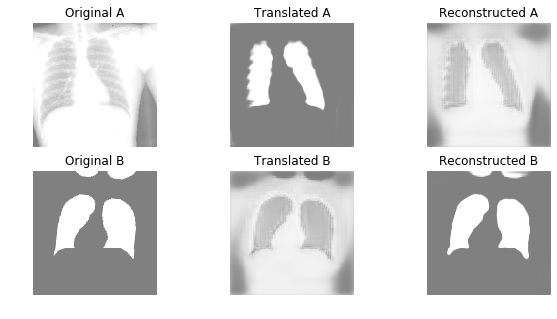

In [22]:
start_time = datetime.datetime.now()

# Adversarial loss ground truths
valid = np.ones((BATCH_SIZE,) + cg.disc_patch)
fake = np.zeros((BATCH_SIZE,) + cg.disc_patch)

for epoch in tqdm_notebook(range(EPOCHS), desc='Epochs'):
    for batch_i, (imgs_A, imgs_B) in tqdm_notebook(enumerate(loader_obj.load_batch(BATCH_SIZE)), desc='Batch'):
        #  Train Discriminators
        if imgs_A is None:
            break
        # Translate images to opposite domain
        fake_B = cg.g_AB.predict(imgs_A)
        fake_A = cg.g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = cg.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = cg.d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = cg.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = cg.d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        
        #  Train Generators
        # Train the generators
        g_loss = cg.combined.train_on_batch([imgs_A, imgs_B],
                                                [valid, valid,
                                                imgs_A, imgs_B,
                                                imgs_A, imgs_B])

        elapsed_time = datetime.datetime.now() - start_time
    
    # Plot the progress at each epoch
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                            % ( epoch, EPOCHS,
                                                                batch_i, loader_obj.n_batches,
                                                                d_loss[0], 100*d_loss[1],
                                                                g_loss[0],
                                                                np.mean(g_loss[1:3]),
                                                                np.mean(g_loss[3:5]),
                                                                np.mean(g_loss[5:6]),
                                                                elapsed_time))
    
    clear_output()
    sample_images(cg, loader_obj, epoch, batch_i)


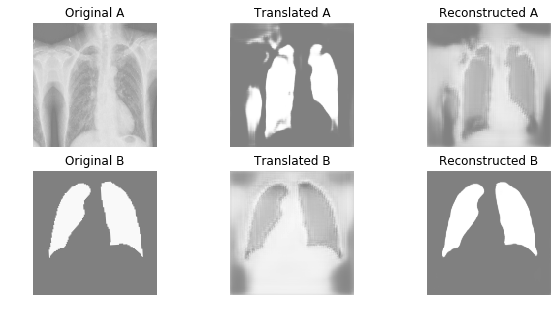

In [23]:
sample_images(cg, loader_obj, EPOCHS, 1)

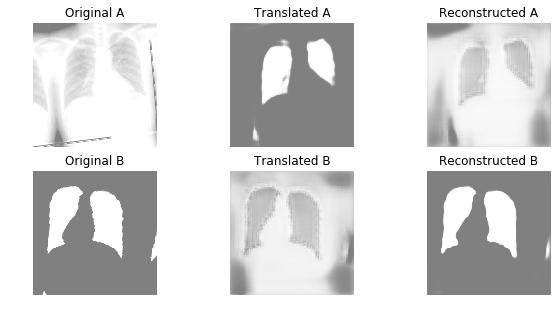

In [24]:
sample_images(cg, loader_obj, EPOCHS, 2)

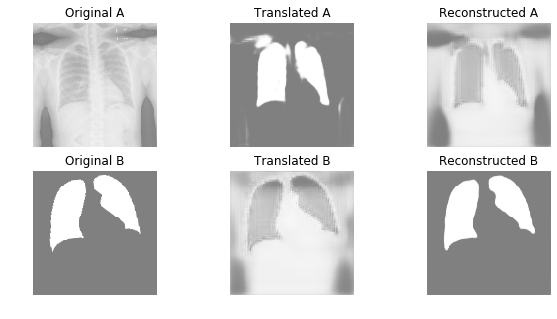

In [25]:
sample_images(cg, loader_obj, EPOCHS, 3)

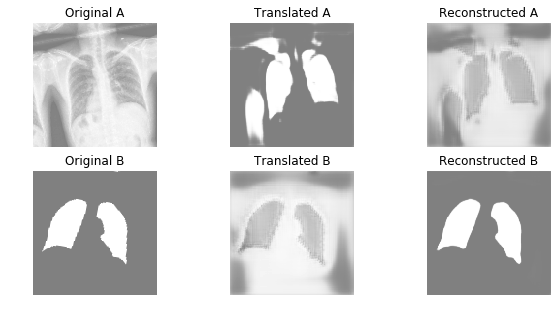

In [26]:
sample_images(cg, loader_obj, EPOCHS, 4)

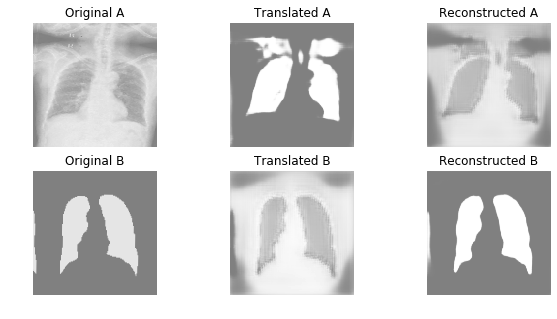

In [27]:
sample_images(cg, loader_obj, EPOCHS, 5)